In [6]:
from visualization.show_bbox import show_two_bounding_boxes
import cv2 
import json 
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from data.torch_data_loaders import homography_dataset
from board_detection.homomography_network import HomographyNet
import tqdm

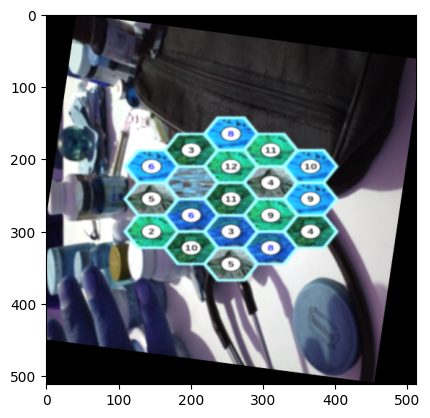

In [35]:
with open('data/full/perspective_distorted_boards/bbox_coordinates.json', 'r') as f:
    data = json.load(f)

img_name = "canvas_image_9.png"
bbox = data[img_name]
homography_matrix = data[f"{img_name}_homography_matrix"]
img = cv2.imread(f"data/full/perspective_distorted_boards/{img_name}")

# show_two_bounding_boxes(bbox, bbox, img)

inverse_matrix = np.linalg.inv(homography_matrix)
affine_matrix = inverse_matrix[:2, :]

(h, w) = img.shape[:2]

transformed_image = cv2.warpAffine(img, affine_matrix, (w, h))
plt.imshow(transformed_image)
plt.show()

In [ ]:
transform_pipeline = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()
])


batch_size = 32
learning_rate = 0.001
num_epochs = 10
json_path = 'data/full/perspective_distorted_boards/bbox_coordinates.json'
img_dir = "data/full/perspective_distorted_boards"

with open(json_path, 'r') as f:
    data = json.load(f)

dataset = homography_dataset.HomographyDataset(json_path, img_dir, transform=transform_pipeline)
train_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Create PyTorch datasets and loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = HomographyNet(9)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in tqdm.tqdm(train_loader):
        # Move tensors to GPU if available
        inputs, labels = inputs, labels
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

  0%|          | 0/4 [01:21<?, ?it/s]


KeyboardInterrupt: 

tensor([ 8.0538e-01, -5.5739e-01,  1.7847e+02,  4.4066e-01,  1.0210e+00,
        -1.1794e+02, -6.6317e-11,  5.8369e-11,  1.0000e+00])
tensor([[  0.7594,  -0.3665,  18.9025,  -0.2260,   1.4222, -34.5232,   1.0028,
           0.0703,   1.2873]], grad_fn=<AddmmBackward0>)


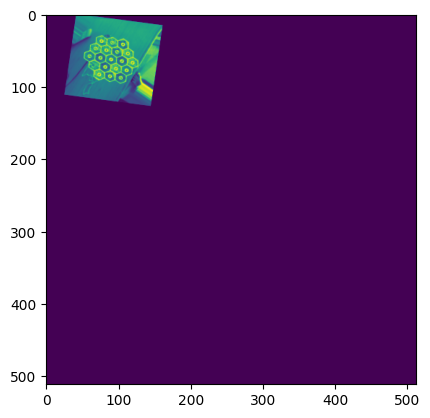

In [ ]:
image, label = dataset.__getitem__(200)
matrix = model(image.unsqueeze(0))

image = image.squeeze().detach().numpy()

print(label)
print(matrix)

label, matrix = label.detach().numpy().reshape(3, 3), matrix.detach().numpy().reshape(3, 3)

[[ 8.0537742e-01 -5.5738658e-01  1.7847435e+02]
 [ 4.4065651e-01  1.0209635e+00 -1.1794394e+02]
 [-6.6316938e-11  5.8368844e-11  1.0000000e+00]]
[[   0.8053774   -0.5573866  178.47435  ]
 [   0.4406565    1.0209635 -117.94394  ]]


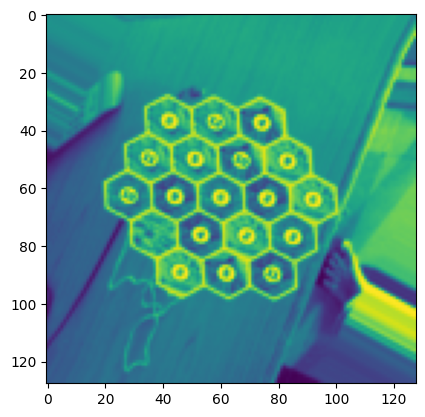

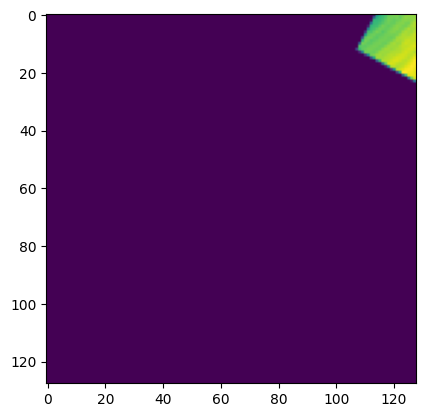

In [34]:
inverse_matrix = np.linalg.inv(label)
affine_matrix = label[:2, :]
print(label)
print(affine_matrix)

(h, w) = image.shape[:2]

plt.imshow(image)
plt.show()

transformed_image = cv2.warpAffine(image, affine_matrix, (w, h))
plt.imshow(transformed_image)
plt.show()


